<a href="https://colab.research.google.com/github/mofuoku417/Machine-Learning-Techniques-for-Multivariate-Time-Series-Forecasting-of-Crude-Palm-Oil-Prices/blob/main/MV_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Objective: Predict Monthly Crude Palm Oil Price Using Long Short Term Memory (LSTM)

###Load Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = (10, 5)
plt.style.use('fivethirtyeight')
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.metrics import explained_variance_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import warnings
warnings.filterwarnings('ignore')
import matplotlib.dates as mdates
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from keras.layers import Dense
from keras.layers import Dropout

###Define Functions to Facilitate Metrics Evaluation

In [2]:
#To compute Mean Directional Accuracy
def mda(actual: np.ndarray, predicted: np.ndarray):
    """ Mean Directional Accuracy """
    return np.mean((np.sign(actual[1:] - actual[:-1]) == np.sign(predicted[1:] - predicted[:-1])).astype(int))

#Calculate the Mean Absolute Percentage Error
#def MAPE(y_true, y_pred): 
    #mape = np.mean(np.abs((np.array(y_true) - np.array(y_pred)) / np.array(y_true))) * 100
    #return mape

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def MAPE(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

#Calculate the Root Mean Squared Error:
def RMSE(y_true, y_pred): 
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return rmse

###Load the Cleaned Data from Github

In [3]:
from pandas import read_csv
path = 'https://raw.githubusercontent.com/mofuoku417/Machine-Learning-Techniques-for-Multivariate-Time-Series-Forecasting-of-Crude-Palm-Oil-Prices/main/Cleaned_data/df_final.csv'
df = read_csv(path)
df.head()

,date,cpo_pri,cno_pri,oli_pri,rps_pri,pno_pri,sbo_pri,sfo_pri,wti_spri,srad,q_mm,humidity
0,2010-12-01,323,455,3102.61,423.45,844.0,468.0,578.0,28.67,207.70504,117.7,79.261905
1,2011-01-01,345,546,3100.45,415.85,799.0,485.0,557.0,24.49,228.94287,4.5,82.193548
2,2011-02-01,362,595,3199.41,410.77,718.0,466.0,552.0,22.06,238.41747,25.1,74.839286
3,2011-03-01,376,636,3281.67,414.82,614.0,442.0,574.0,21.64,218.47599,53.6,77.935484
4,2011-04-01,383,738,3261.65,451.04,619.0,429.0,595.0,22.30,226.15010,166.0,80.450000


In [4]:
df.index = pd.to_datetime(df['date'], format='%Y.%m.%d')
del df['date']

In [5]:
df.head()

,cpo_pri,cno_pri,oli_pri,rps_pri,pno_pri,sbo_pri,sfo_pri,wti_spri,srad,q_mm,humidity
date,,,,,,,,,,,
2010-12-01,323,455,3102.61,423.45,844.0,468.0,578.0,28.67,207.70504,117.7,79.261905
2011-01-01,345,546,3100.45,415.85,799.0,485.0,557.0,24.49,228.94287,4.5,82.193548
2011-02-01,362,595,3199.41,410.77,718.0,466.0,552.0,22.06,238.41747,25.1,74.839286
2011-03-01,376,636,3281.67,414.82,614.0,442.0,574.0,21.64,218.47599,53.6,77.935484
2011-04-01,383,738,3261.65,451.04,619.0,429.0,595.0,22.30,226.15010,166.0,80.450000


###Plot the Target Variable

Text(0.5, 0, 'Date')

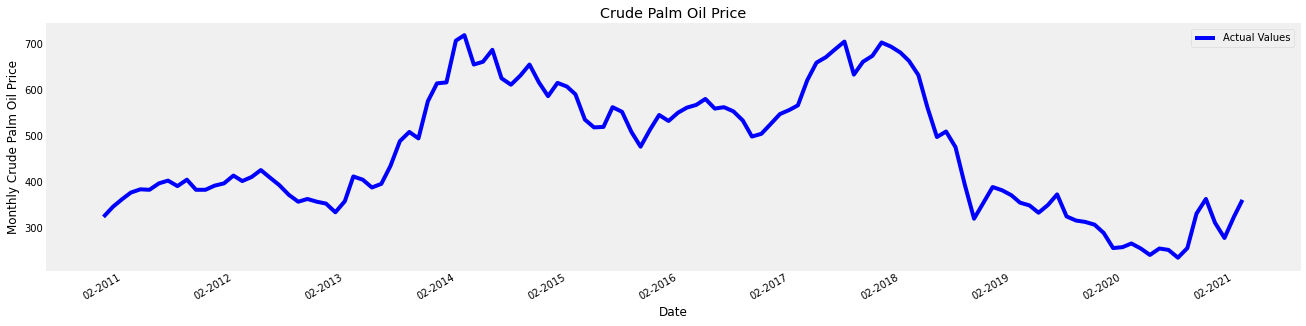

In [6]:
plt.figure(figsize=(20,5))
plt.grid()
plt.plot(df.index, df['cpo_pri'], color = 'blue',  label = 'Test')
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=12))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
plt.gcf().autofmt_xdate() # Rotation
plt.legend(['Actual Values', 'Crude Palm Oil Price 2002-2021'],loc='best')
plt.title('Crude Palm Oil Price')
plt.ylabel('Monthly Crude Palm Oil Price')
plt.xlabel('Date')

###Visualize Multiple Time Series

In [7]:
fig = make_subplots(rows=6, cols=1)
fig.add_trace(
    go.Scatter(x=df.reset_index()['date'], y=df.reset_index()['cpo_pri'],name='crude palm oil price'),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(x=df.reset_index()['date'], y=df.reset_index()['cno_pri'],name='coconut oil price'),
    row=2, col=1
)
fig.add_trace(
    go.Scatter(x=df.reset_index()['date'], y=df.reset_index()['rps_pri'],name='rapeseed oil price'),
    row=3, col=1
)
fig.add_trace(
    go.Scatter(x=df.reset_index()['date'], y=df.reset_index()['pno_pri'],name='peanut oil price'),
    row=4, col=1
)
fig.add_trace(
    go.Scatter(x=df.reset_index()['date'], y=df.reset_index()['sbo_pri'],name='soybean oil price'),
    row=4, col=1
)
fig.add_trace(
    go.Scatter(x=df.reset_index()['date'], y=df.reset_index()['wti_spri'],name='west texas intermediate spot price'),
    row=4, col=1

)
fig.update_layout(height=1000, width=1200, title_text="Time Series")
fig.show()

<Figure size 1800x720 with 0 Axes>

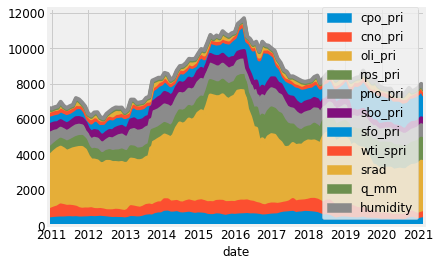

In [8]:
# Plot an area chart
plt.figure(figsize=(25,10))
ax = df.plot.area(fontsize=12);

# Additional customizations
ax.set_xlabel('date');
ax.legend(fontsize=12);

##**Long Term Short Forecasting Technique**

###**Split Data into Train Test Segments**

In [9]:
train_size = int(len(df) * 0.8)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print('Train size:',len(train))
print('Test size:', len(test))

Train size: 99
Test size: 25


In [10]:
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(len(train), len(test))

99 25


In [11]:
print(train.shape)
train.head()

(99, 11)


,cpo_pri,cno_pri,oli_pri,rps_pri,pno_pri,sbo_pri,sfo_pri,wti_spri,srad,q_mm,humidity
date,,,,,,,,,,,
2010-12-01,323,455,3102.61,423.45,844.0,468.0,578.0,28.67,207.70504,117.7,79.261905
2011-01-01,345,546,3100.45,415.85,799.0,485.0,557.0,24.49,228.94287,4.5,82.193548
2011-02-01,362,595,3199.41,410.77,718.0,466.0,552.0,22.06,238.41747,25.1,74.839286
2011-03-01,376,636,3281.67,414.82,614.0,442.0,574.0,21.64,218.47599,53.6,77.935484
2011-04-01,383,738,3261.65,451.04,619.0,429.0,595.0,22.30,226.15010,166.0,80.450000


###Rescale train dataset

In [13]:
#f_transformer = RobustScaler()
f_transformer = MinMaxScaler()
feature_columns = ['cno_pri', 'oli_pri', 'rps_pri', 'pno_pri', 'sbo_pri', 'sfo_pri',
                   'wti_spri', 'srad', 'q_mm', 'humidity']
f_transformer = f_transformer.fit(train[feature_columns].to_numpy())
train.loc[:, feature_columns] = f_transformer.transform(train[feature_columns].to_numpy())
train.head()

,cpo_pri,cno_pri,oli_pri,rps_pri,pno_pri,sbo_pri,sfo_pri,wti_spri,srad,q_mm,humidity
date,,,,,,,,,,,
2010-12-01,323,0.112288,0.140918,0.010736,0.528090,0.253193,0.023302,0.109026,0.617026,0.366984,0.843364
2011-01-01,345,0.305085,0.140327,0.004301,0.443820,0.306536,0.009321,0.044200,0.815738,0.007619,0.983088
2011-02-01,362,0.408898,0.167408,0.000000,0.292135,0.246917,0.005992,0.006514,0.904388,0.073016,0.632580
2011-03-01,376,0.495763,0.189919,0.003429,0.097378,0.171609,0.020639,0.000000,0.717805,0.163492,0.780147
2011-04-01,383,0.711864,0.184440,0.034095,0.106742,0.130817,0.034621,0.010236,0.789608,0.520317,0.899990


In [14]:
cpo_pri_transformer = MinMaxScaler()
cpo_pri_transformer = cpo_pri_transformer.fit(train[['cpo_pri']])
train['cpo_pri'] = cpo_pri_transformer.transform(train[['cpo_pri']])
train['cpo_pri'].head()

date
2010-12-01    0.0100
2011-01-01    0.0650
2011-02-01    0.1075
2011-03-01    0.1425
2011-04-01    0.1600
Name: cpo_pri, dtype: float64

In [15]:
test.loc[:, feature_columns] = f_transformer.transform(test[feature_columns].to_numpy())
test.head()

,cpo_pri,cno_pri,oli_pri,rps_pri,pno_pri,sbo_pri,sfo_pri,wti_spri,srad,q_mm,humidity
date,,,,,,,,,,,
2019-03-01,354,0.637712,0.194855,0.382454,0.381292,-0.039662,0.493342,0.455180,0.707023,0.548889,0.265874
2019-04-01,348,0.533898,0.264388,0.393951,0.213633,-0.054975,0.597870,0.515974,0.732180,0.017143,0.437683
2019-05-01,332,0.400424,0.246417,0.453802,0.235262,-0.092159,0.606525,0.530397,0.708895,0.444127,0.349664
2019-06-01,349,0.317797,0.234308,0.509834,0.320749,-0.074743,0.631824,0.593207,0.808476,0.181905,0.645800
2019-07-01,372,0.313559,0.223422,0.526454,0.426610,-0.066114,0.773462,0.641749,0.866202,0.436825,0.577974


In [16]:
test['cpo_pri'] = cpo_pri_transformer.transform(test[['cpo_pri']])
test['cpo_pri'].head()

date
2019-03-01    0.0875
2019-04-01    0.0725
2019-05-01    0.0325
2019-06-01    0.0750
2019-07-01    0.1325
Name: cpo_pri, dtype: float64

###Create X_train, y_train, X_test and y_test

In [17]:
def createDataset(X, y, time_steps):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        data = X.iloc[i:(i + time_steps)].values
        Xs.append(data)        
        ys.append(y.iloc[i + time_steps])
        
    return np.array(Xs), np.array(ys)

time_steps = 3
X_train, y_train = createDataset(train, train.cpo_pri, time_steps)
X_test, y_test = createDataset(test, test.cpo_pri, time_steps)
print(X_train.shape, y_train.shape)

(96, 3, 11) (96,)


###Create Model

####Declare input shape

In [18]:
lstm_model = tf.keras.Sequential()
lstm_model.add(tf.keras.layers.LSTM(units=128, input_shape=(X_train.shape[1], X_train.shape[2])))
lstm_model.add(tf.keras.layers.Dropout(rate=0.2))
lstm_model.add(tf.keras.layers.Dense(units=1))
lstm_model.compile(loss='mse', optimizer='adam')

In [19]:
lstm_history = lstm_model.fit(X_train, y_train,epochs=50,batch_size=32,validation_split=0.1,shuffle=False)

Epoch 1/50
3/3 [==============================] - 3s 273ms/step - loss: 0.2947 - val_loss: 0.0429
Epoch 2/50
3/3 [==============================] - 0s 17ms/step - loss: 0.1176 - val_loss: 0.0314
Epoch 3/50
3/3 [==============================] - 0s 17ms/step - loss: 0.0306 - val_loss: 0.0822
Epoch 4/50
3/3 [==============================] - 0s 17ms/step - loss: 0.0296 - val_loss: 0.1481
Epoch 5/50
3/3 [==============================] - 0s 17ms/step - loss: 0.0539 - val_loss: 0.1709
Epoch 6/50
3/3 [==============================] - 0s 17ms/step - loss: 0.0564 - val_loss: 0.1435
Epoch 7/50
3/3 [==============================] - 0s 17ms/step - loss: 0.0468 - val_loss: 0.1011
Epoch 8/50
3/3 [==============================] - 0s 22ms/step - loss: 0.0255 - val_loss: 0.0677
Epoch 9/50
3/3 [==============================] - 0s 20ms/step - loss: 0.0265 - val_loss: 0.0482
Epoch 10/50
3/3 [==============================] - 0s 18ms/step - loss: 0.0276 - val_loss: 0.0398
Epoch 11/50
3/3 [===========

dict_keys(['loss', 'val_loss'])


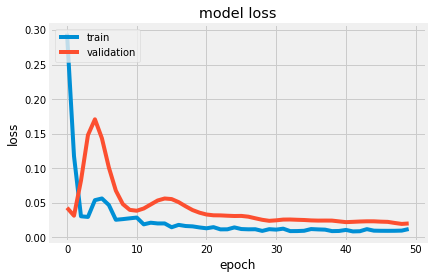

In [20]:
print(lstm_history.history.keys())
plt.plot(lstm_history.history['loss'])
plt.plot(lstm_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

The plot show that there is overfitting which means that there is room for improvement.

###Model Summary

In [21]:
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               71680     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 71,809
Trainable params: 71,809
Non-trainable params: 0
_________________________________________________________________


###Predict the Test Data

In [22]:
y_pred = lstm_model.predict(X_test)
y_pred

array([[0.16033861],
       [0.16192387],
       [0.17460954],
       [0.18415286],
       [0.15041415],
       [0.10209043],
       [0.08149625],
       [0.07228333],
       [0.05255117],
       [0.05502308],
       [0.05567718],
       [0.05305678],
       [0.05354141],
       [0.06295617],
       [0.08509278],
       [0.0877739 ],
       [0.04962991],
       [0.05309555],
       [0.12263226],
       [0.19772668],
       [0.1958456 ],
       [0.1694344 ]], dtype=float32)

In [23]:
y_pred.reshape(1,-1)

array([[0.16033861, 0.16192387, 0.17460954, 0.18415286, 0.15041415,
        0.10209043, 0.08149625, 0.07228333, 0.05255117, 0.05502308,
        0.05567718, 0.05305678, 0.05354141, 0.06295617, 0.08509278,
        0.0877739 , 0.04962991, 0.05309555, 0.12263226, 0.19772668,
        0.1958456 , 0.1694344 ]], dtype=float32)

###Invert Transformed Data

In [24]:
y_train_inv = cpo_pri_transformer.inverse_transform(y_train.reshape(1, -1))
y_test_inv = cpo_pri_transformer.inverse_transform(y_test.reshape(1, -1))
y_pred_inv = cpo_pri_transformer.inverse_transform(y_pred.reshape(1,-1))
print(y_train_inv)
print(y_test_inv)
print(y_pred_inv)

[[376. 383. 382. 396. 402. 390. 404. 382. 382. 391. 396. 413. 401. 410.
  425. 408. 392. 371. 356. 362. 356. 352. 333. 357. 411. 404. 387. 395.
  434. 488. 508. 494. 575. 614. 616. 707. 719. 655. 661. 687. 625. 611.
  631. 655. 616. 586. 615. 607. 590. 535. 518. 519. 562. 552. 508. 476.
  513. 545. 532. 550. 561. 567. 580. 559. 562. 553. 533. 498. 504. 525.
  547. 556. 566. 621. 659. 671. 688. 705. 633. 661. 674. 703. 694. 681.
  663. 632. 561. 497. 509. 475. 392. 319. 354. 388. 381. 370.]]
[[349. 372. 324. 315. 312. 306. 288. 255. 257. 265. 254. 240. 254. 251.
  234. 255. 330. 362. 310. 277. 323. 360.]]
[[383.13544 383.76956 388.8438  392.66113 379.16568 359.83618 351.5985
  347.91333 340.02048 341.00925 341.27087 340.22272 340.41656 344.18246
  353.0371  354.10956 338.852   340.23822 368.05292 398.09067 397.33826
  386.77374]]


###Plot History, Actual and Predicted Value

In [25]:
y_train_inv = y_train_inv.flatten()
y_train_inv

array([376., 383., 382., 396., 402., 390., 404., 382., 382., 391., 396.,
       413., 401., 410., 425., 408., 392., 371., 356., 362., 356., 352.,
       333., 357., 411., 404., 387., 395., 434., 488., 508., 494., 575.,
       614., 616., 707., 719., 655., 661., 687., 625., 611., 631., 655.,
       616., 586., 615., 607., 590., 535., 518., 519., 562., 552., 508.,
       476., 513., 545., 532., 550., 561., 567., 580., 559., 562., 553.,
       533., 498., 504., 525., 547., 556., 566., 621., 659., 671., 688.,
       705., 633., 661., 674., 703., 694., 681., 663., 632., 561., 497.,
       509., 475., 392., 319., 354., 388., 381., 370.])

In [26]:
y_test_inv = y_test_inv.flatten()
y_test_inv

array([349., 372., 324., 315., 312., 306., 288., 255., 257., 265., 254.,
       240., 254., 251., 234., 255., 330., 362., 310., 277., 323., 360.])

In [27]:
y_pred_inv = y_pred_inv.flatten()
y_pred_inv

array([383.13544, 383.76956, 388.8438 , 392.66113, 379.16568, 359.83618,
       351.5985 , 347.91333, 340.02048, 341.00925, 341.27087, 340.22272,
       340.41656, 344.18246, 353.0371 , 354.10956, 338.852  , 340.23822,
       368.05292, 398.09067, 397.33826, 386.77374], dtype=float32)

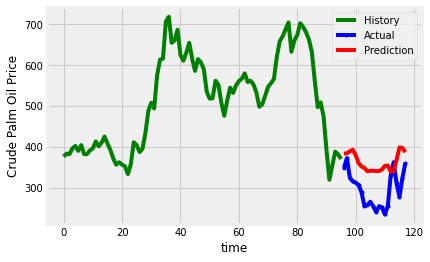

In [28]:
plt.plot(np.arange(0, len(y_train)), y_train_inv, color='green', label="History")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_inv, color='blue', marker='.', label="Actual")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred_inv, color='red', label="Prediction")
plt.ylabel('Crude Palm Oil Price')
plt.xlabel('time')
plt.legend()
plt.show();

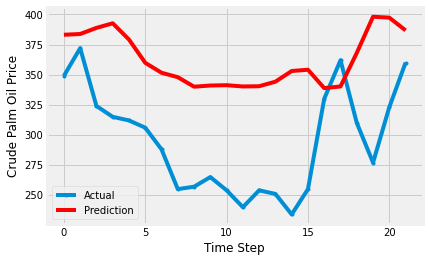

In [29]:
plt.plot(y_test_inv, marker='.', label="Actual")
plt.plot(y_pred_inv, color='red', label="Prediction")
plt.ylabel('Crude Palm Oil Price')
plt.xlabel('Time Step')
plt.legend()
plt.show();

###Evaluate LSTM Model Accuracy

In [30]:
MAE_lstm = mean_absolute_error(y_test_inv, y_pred_inv)
print('MAE value of the LSTM Model is:', MAE_lstm)

MDA_lstm = mda(y_test_inv, y_pred_inv)
print('MDA value of the LSTM Model is:', MDA_lstm)

MAPE_lstm = mean_absolute_percentage_error(y_test_inv, y_pred_inv)
print('MAPE value of the LSTM Model is:', MAPE_lstm)

RMSE_lstm = mean_squared_error(y_test_inv,y_pred_inv, squared=False)
print('RMSE value of the LSTM Model is:', RMSE_lstm)

MSE_lstm = mean_squared_error(y_test_inv,y_pred_inv)
print('MSE value of the LSTM Model is:', MSE_lstm)

EVS_lstm = explained_variance_score(y_test_inv, y_pred_inv)
print('EVS score of the LSTM Model is:', EVS_lstm)

MAE value of the LSTM Model is: 69.13918235085227
MDA value of the LSTM Model is: 0.47619047619047616
MAPE value of the LSTM Model is: 25.219508767059917
RMSE value of the LSTM Model is: 75.95719851765261
MSE value of the LSTM Model is: 5769.496006650088
EVS score of the LSTM Model is: 0.29713290255583713


In [ ]:
#...updating